<a href="https://colab.research.google.com/github/Ayushsrinivas7/Project_GPT_Classifer/blob/main/Project_Redesiging__GPT2_for_classification_%26_finetuning_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install tiktoken  tensorflow>=2.15.0 tqdm>=4.66 transformers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
import torch
from torch import nn
import pandas



## THE STAGES OF THE PROJECT

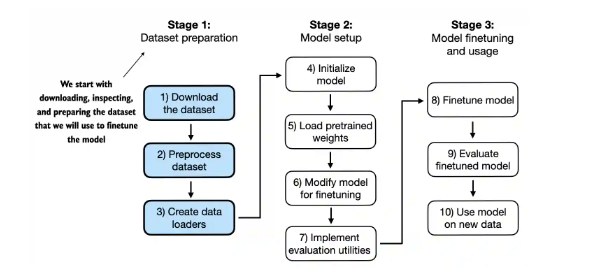

STEP 1:

```
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
```
this is the url for the spam not spam dataset


In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path
# the path object will have some additional properties that makes us easy handeling the paths

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# when i dowloaded it using urllib  we have the file sms_spam_collection.zip so save the path
zip_path = "sms_spam_collection.zip"
# now we have to unzip it see the cloab above provided for understanding how to unzip the zip file
# when  we unzip it we will get the folder "sms_spam_collection"
extracted_path = "sms_spam_collection"
# now in this foldar the data is stored as tsv(table seperated value file ) file named SMSSpamCollection
# so lets extract data and convert it into the dataframe
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

# LEts define a function for downloading the files
def download_and_unzip_spam_data(url , zip_path , extracted_path , data_file_path):
  if data_file_path.exists():
    print(f" {data_file_path} already exists . skipping the dowloading part ")
    return

  # downloading the files
  with urllib.request.urlopen(url) as response :
     with open(zip_path, "wb") as out_file:
       out_file.write(response.read())

   # Unzipping the file
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

  # adding .tsv extension
  orginal_file_path  = Path(extracted_path)/"SMSSpamCollection"
  os.rename(orginal_file_path , data_file_path )
  print(f"File downloaded and saved as {data_file_path}")


In [ ]:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


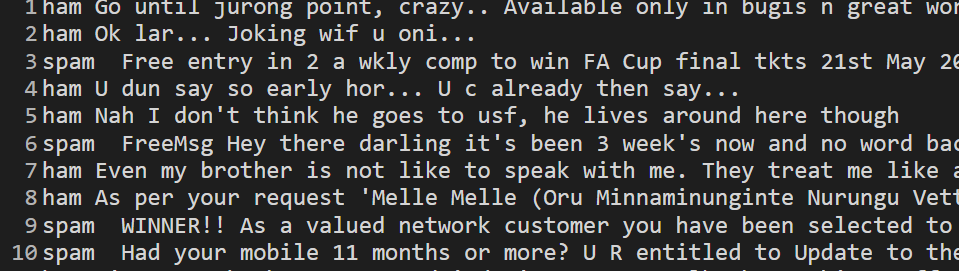

## this is how the dataset look like after downloading and unzipping it

## we will store the data as the tsv file becuase it will not cause any issue with the comma .

In [ ]:
import pandas as pd

df = pd.read_csv(data_file_path , sep = "\t" , header = None , names = ["Label" , "Text"] )
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


When we check the class distribution, we see that the data contains "ham" (i.e., "not spam") much more frequently than "spam" <br>



STEP2 : PRE Proecess the dataset
<br>
## lets balance the dataset

In [ ]:
def create_balanced_dataset(df):
  # num of spam
  num_spam = df[df["Label"] == "spam"].shape[0]
  # Randomly sample "ham" instances that are equal to spam number
  ham_subset = df[df['Label'] == "ham"].sample(num_spam , random_state = 123 )
  # combining the both
  balanced_df = pd.concat([ham_subset , df[df["Label"] == "spam"] ])
  return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [ ]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


STEP3 : here will first split the data into train , test , split an then we will -> create a dataset class where will  send the data and it will have the methos like len , getindx whcih will be used by the dataloader for making the batches

In [ ]:
def random_split(df , train_frac , validation_frac ):
  # shuffle the entire dataframe
  df = df.sample(frac = 1 , random_state = 123 ).reset_index(drop = True)

  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)
  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df , validation_df , test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

## we will save the data in csv so that in future we can use it

In [ ]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


AS WE DISCUSSED dataset->dataloader

In [ ]:
from torch.utils.data import Dataset , DataLoader

In [ ]:
class SpamDataset(Dataset):
  def __init__(self , csv_file , tokenizer , max_length = None , pad_token_id = 50256):
    self.data = pd.read_csv(csv_file)

    self.encoded_texts = [
        tokenizer.encode(text) for text in self.data["Text"]
    ]

    if max_length == None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      self.encoded_texts = [
          encoded_text[:self.max_length] for encoded_text in self.encoded_texts
      ]

    # pad sequences to the longest  sequence
    self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

  def __getitem__(self , index ):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

  def __len__(self):
        return len(self.data)


  def _longest_encoded_length(self):

    return max(len(encoded_text) for encoded_text in self.encoded_texts)






In [ ]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


We also pad the validation and test set to the longest training sequence
Note that validation and test set samples that are longer than the longest training example are being truncated via encoded_text[:self.max_length] in the SpamDataset code
This behavior is entirely optional, and it would also work well if we set max_length=None in both the validation and test set cases

In [ ]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [ ]:
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,

    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,

    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,

    drop_last=False,
)

As a verification step, we iterate through the data loaders and ensure that the batches contain 8 training examples each, where each training example consists of 120 tokens

In [ ]:

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## now lets build the model .


## THE CODE FOR THE GPT MODEL IS GIVEN IN THE PREVIOUS COLAB HERE WHAT WE ARE DOING IS WE WILL LOAD A MODEL GPT USING THE GPT2_model.py file where all the code of ours is present .

STRATEGY : 1) we will load the model of our own .
2) we will load the gpt model parametrs fromt he huggiing face
3) we will copy the parameters from the hugging face to our own model
4) then we can use our model and do changes to the model according to our own wish

--> our model  loading

In [ ]:
from GPT2_model_new import GPTModel


In [ ]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"


BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [ ]:
import torch

def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())

In [ ]:
import numpy as np


def load_weights(gpt, gpt_hf):

    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])

    for b in range(BASE_CONFIG["n_layers"]):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign_check(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign_check(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign_check(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign_check(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign_check(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign_check(gpt.trf_blocks[b].att.W_value.bias, v_b)


        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])

        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])

        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])

hugging face model

In [ ]:
from transformers import GPT2Model

In [ ]:
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

CHOOSE_MODEL = "gpt2-small (124M)"

gpt_hf = GPT2Model.from_pretrained(model_names[CHOOSE_MODEL], cache_dir="checkpoints")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
gpt_hf.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

--> copying the hugging face parameters .

In [ ]:
gpt = GPTModel(BASE_CONFIG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights(gpt, gpt_hf)

In [ ]:
def generate(model , idx , max_new_tokens , context_size , temperature = 1.4 , top_k = None , eos_id = None ):
  device = idx.device
  model.to(device)
  for _ in range(max_new_tokens):
    idx_cond = idx[: , -context_size:]
    # logit cal
    with torch.no_grad():
      logits = model(idx_cond)
    # taking logits in last row of every batch
    logits = logits[ : , -1 , : ]
    # New : Filter logits with top_k sampling
    if top_k is not None :
      top_logits , _ = torch.topk(logits , top_k)
      min_val = top_logits[: , -1]
      logits = torch.where(logits < min_val  , torch.tensor(float("-inf")).to(logits.device) , logits )

    # New : apply temperature scaling
    if temperature > 0.0 :
      logits = logits / temperature
      probas = torch.softmax(logits, dim = -1 )
      idx_next = torch.multinomial(probas , num_samples = 1)

    else:
      idx_next = torch.argmax(logits , dim = -1 , keepdim = True )

    if idx_next == eos_id :
      break

    idx = torch.cat((idx , idx_next) , dim = 1 )


  return idx







In [ ]:
import tiktoken
from  GPT2_model_new import  text_to_token_ids, token_ids_to_text

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


BY NOW WE HAVE BUILT THE MODEL AND LOADED IT WITH PRETRAIN WEIGHTS .
this is my colab for reff : https://colab.research.google.com/drive/1jP2EoortmGsFcprBYq7AMpDh_s0mru5H?usp=sharing

In [ ]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' referring Purir Puedock business reserves available to the holders containing these www regexv conventions

trans Synteen


## LETS START CHANGING THE ARCHITECTURE .
-> we want classifier of spam or not spam so we want the output dim to be two

In [ ]:
print(gpt)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

now we have to build the classifier . for that we dont need to make pretraing the entire architecture

SO lets freeze the prameters and then make the change.

In [ ]:
for param in gpt.parameters():
  param.requires_grad = False

 (out_head): Linear(in_features=768, out_features=50257, bias=False)


we will now replace the layer of 768 x 50257 with 768 x 2 as we need spam and not spam .

Note that we use BASE_CONFIG["emb_dim"] (which is equal to 768 in the "gpt2-small (124M)" model) to keep the code below more general

In [ ]:
torch.manual_seed(123)
num_classes = 2
gpt.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

echnically, it's sufficient to only train the output layer
However, as I found in Finetuning Large Language Models, experiments show that finetuning additional layers can noticeably improve the performance
So, we are also making the last transformer block and the final LayerNorm module connecting the last transformer block to the output layer trainable

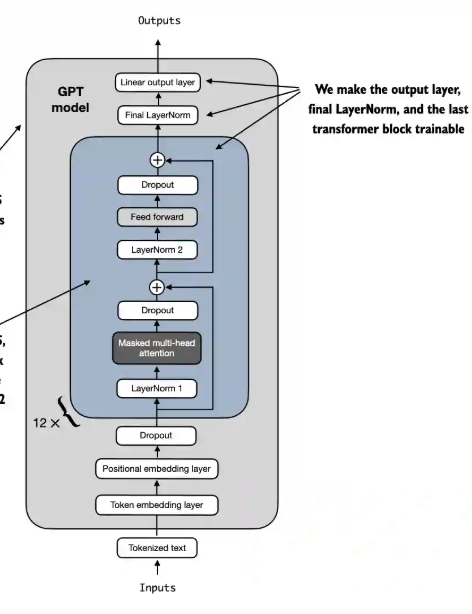

## so lets mak e the last transformer block params and last layer norm trainable

In [ ]:
for param in gpt.trf_blocks[-1].parameters():
  param.requires_grad = True

for param in gpt.final_norm.parameters():
  param.requires_grad = True



lets test the model

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [ ]:
with torch.no_grad():
  # always at the inference we will make the model
  # in nograd condition
  outputs = gpt(inputs)
print(outputs)
print(outputs.shape) # shape: (batch_size, num_tokens, num_classes)

tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
torch.Size([1, 4, 2])


Since we fed the model a text sample with 4 input tokens, the output consists of 4 2-dimensional output vectors above

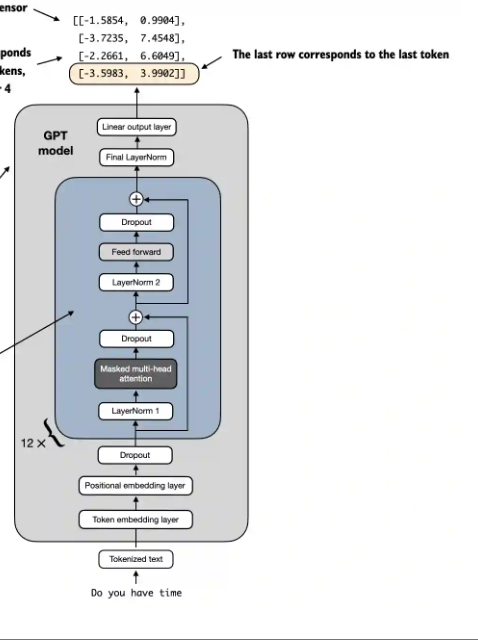

we know that the vector at the last token has seen all the data so the vector corresponding to it is taken for the result

In [ ]:
req_output = outputs[: , -1 , :]
print("Last output token:" , req_output)

Last output token: tensor([[-3.5983,  3.9902]])


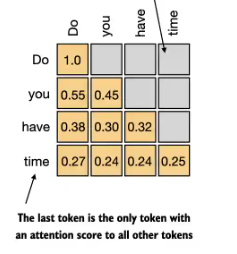

this is because of the causal attention

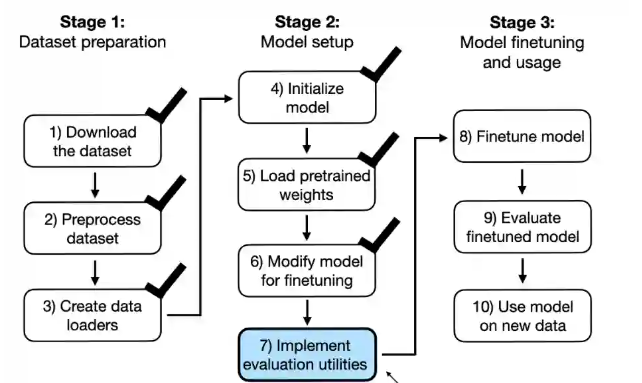

WE know the ai is all about the data -> some model -> loss function . ALL WE DO is the decrease the loss function.

in the llm pretraining the loss is the average negitive log likely hood of probabalities if the target tokens in the predicted output softamx.

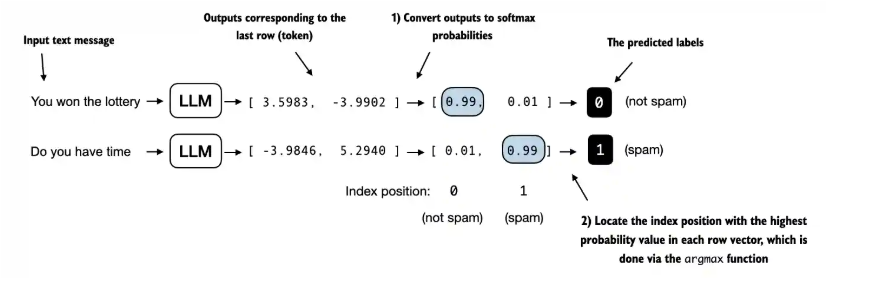

In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [ ]:
req_outputs = outputs[:, -1, :]
probas = torch.softmax(req_outputs , dim = -1 )
res = torch.argmax( probas, dim = -1 )
print("req_outputs : " , req_outputs )
print("probas " , probas )
print("result" , res )

req_outputs :  tensor([[-3.5983,  3.9902]])
probas  tensor([[5.0598e-04, 9.9949e-01]])
result tensor([1])


## lets define a function to calculate the accuracy .
Its simple maths (num of correct / total number of samples )* 100

In [ ]:
def accuracy(dataloader , model , device  , num_batches = None  ):
  model.eval()
  tot_sam , num_crct = 0 , 0

  if num_batches == None :
    num_batches = len(dataloader)
  else :
    num_batches = min(len(dataloader) , num_batches)

  for i , (input , target ) in enumerate(dataloader):

    if i < num_batches :
      with torch.no_grad():
        logits = model(input)

      res = torch.argmax(logits[: , -1 , : ])

      num_crct += sum(res == target )
      tot_sam += len(target)
    else:
      break

  return (num_crct / tot_sam) * 100



In [ ]:
accuracy(test_loader , gpt , 'cpu'  )

tensor(4.3333)

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [ ]:
calc_accuracy_loader(test_loader , gpt , 'cpu' )

0.5033333333333333

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, gpt, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Accuracies are not good as the model has is yet not finetuned

see this code if you want to add new laers to the existing model and finetune it .

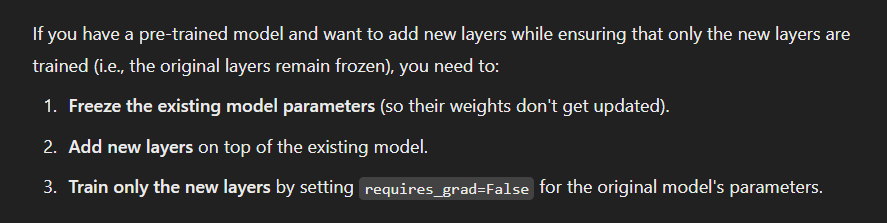

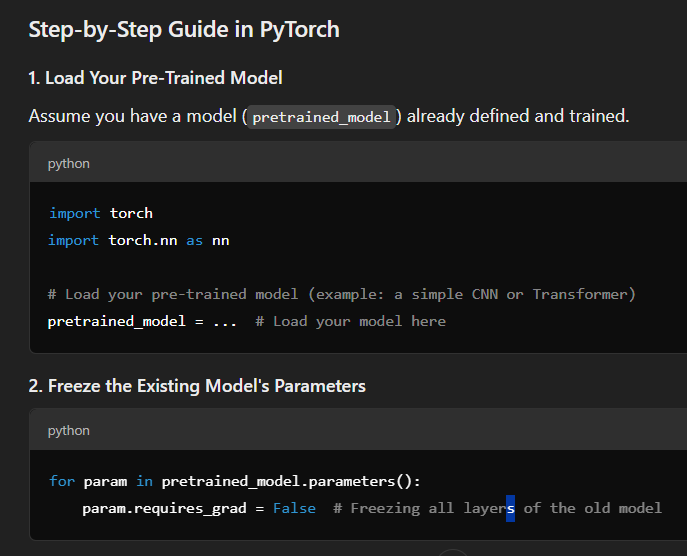

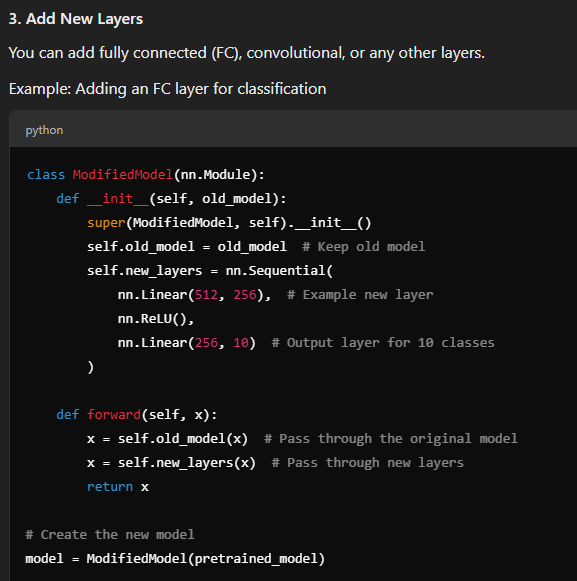

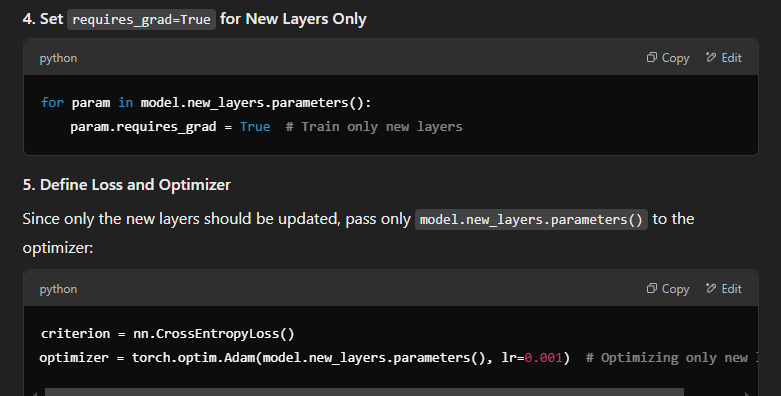

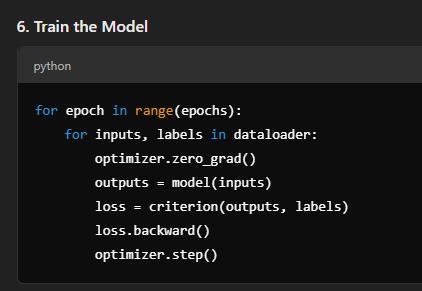

The calc_loss_batch function is the same like before ie the full gpt generative task , except that we are only interested in optimizing the last token model(input_batch)[:, -1, :] instead of all tokens model(input_batch)

cross entropy loss is so important

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device= 'cpu'):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, gpt, device )
    val_loss = calc_loss_loader(val_loader, gpt, device )
    test_loss = calc_loss_loader(test_loader, gpt, device )

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.604
Validation loss: 2.459
Test loss: 2.515


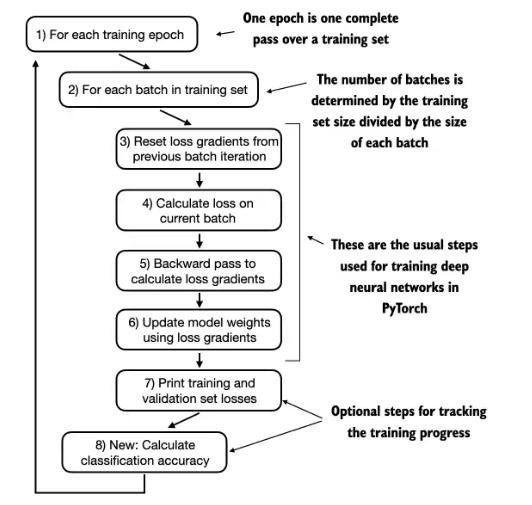

Step 1: Set model to training mode

Step 2: Reset loss gradients from previous batch iteration

Step 3: Calculate loss gradients

Step 4: Update model weights using loss gradients

Step 5: New: track examples instead of tokens

Step 6: Optional evaluation step

Step 7: Calculate accuracy after each epoch

In [ ]:

def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen









In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 9
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 6 (Step 000650): Train los

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

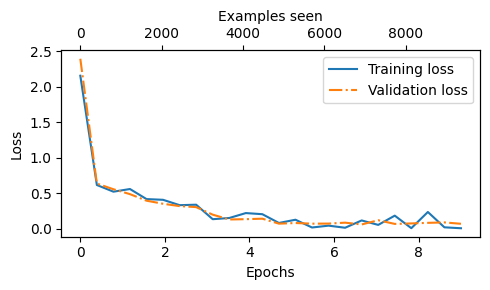

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Above, based on the downward slope, we see that the model learns well
Furthermore, the fact that the training and validation loss are very close indicates that the model does not tend to overfit the training data
Similarly, we can plot the accuracy below

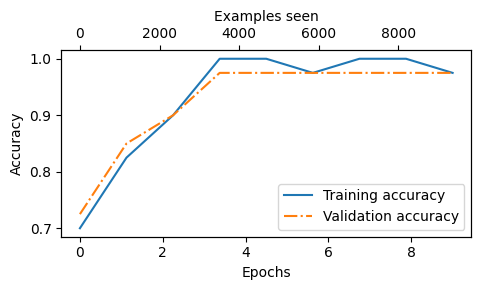

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

Based on the accuracy plot above, we can see that the model achieves a relatively high training and validation accuracy after epochs 4 and 5
However, we have to keep in mind that we specified eval_iter=5 in the training function earlier, which means that we only estimated the training and validation set performances
We can compute the training, validation, and test set performances over the complete dataset as follows below

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.94%
Validation accuracy: 97.99%
Test accuracy: 95.67%


We can see that the training and validation set performances are practically identical
However, based on the slightly lower test set performance, we can see that the model overfits the training data to a very small degree, as well as the validation data that has been used for tweaking some of the hyperparameters, such as the learning rate
This is normal, however, and this gap could potentially be further reduced by increasing the model's dropout rate (drop_rate) or the weight_decay in the optimizer setting

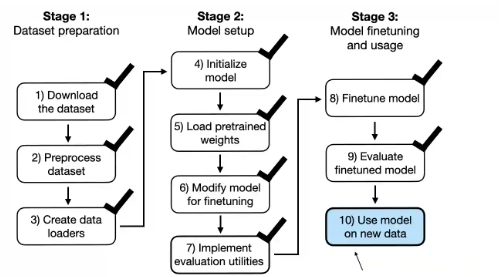

In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, gpt, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [ ]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, gpt, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [ ]:
torch.save(gpt.state_dict(), "review_classifier.pth")

In [ ]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
gpt.load_state_dict(model_state_dict)

<All keys matched successfully>